In [1]:
import os

import logs_analyzer as analyzer
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from pathlib import Path
import tarfile
import shutil

plt.style.use({'figure.facecolor':'white'})

In [2]:
PROTOCOLS = {"bracha", "scalable", "witness"}
COMPRESSED = "compressed"
LOG_DIR = "logs"

ns = [16, 32, 64, 96, 128, 160, 192, 224, 256]

In [3]:
config_statistics = {}

for compressed_file in listdir(COMPRESSED):
    os.mkdir(LOG_DIR)

    params = compressed_file.removesuffix(".tar.gz")
    with tarfile.open(join(COMPRESSED, compressed_file)) as file:
        file.extractall(LOG_DIR)

    ind = params.find("config")
    splitted_dir = params[ind:].split("_")
    thr = int(splitted_dir[1])
    protocol, i = params[:ind].split("Input")
    n = ns[int(i)]

    print(params)

    if config_statistics.get(n) is None:
        config_statistics[n] = {}
    if config_statistics[n].get(protocol) is None:
        config_statistics[n][protocol] = {}

    config_statistics[n][protocol][thr] = \
        analyzer.calculate_stat(
            directory=join(LOG_DIR, "outputs"),
            n=n
        )

    shutil.rmtree(LOG_DIR)

scalableInput0config16_162
witnessInput0config16_6
scalableInput5config16_512
scalableInput4config16_41
brachaInput4config16_4
brachaInput0config16_32
scalableInput5config16_7
scalableInput0config16_51
brachaInput4config16_41
scalableInput8config16_512
scalableInput0config16_32
brachaInput0config16_51
witnessInput4config16_64
brachaInput1config16_407
brachaInput1config16_256
witnessInput2config16_7
scalableInput7config16_6
brachaInput4config16_8
scalableInput1config16_323
witnessInput7config16_11
scalableInput4config16_102
brachaInput8config16_81
scalableInput8config16_204
brachaInput0config16_16
witnessInput2config16_407
brachaInput2config16_7
witnessInput2config16_256
scalableInput0config16_16
scalableInput3config16_4
scalableInput7config16_128
witnessInput4config16_8
scalableInput8config16_81
scalableInput5config16_204
scalableInput3config16_8
witnessInput0config16_21
brachaInput0config16_6
witnessInput3config16_13
brachaInput7config16_26
witnessInput4config16_4
scalableInput7config

In [ ]:
def get_stat(mode="stress"):
    statistics = {}

    for directory in listdir(LOG_DIR):
        if not isdir(join(LOG_DIR, directory)):
            continue

        ind = directory.find(mode)
        if ind == -1:
            continue

        if mode == "config":
            splitted_dir = directory[ind:].split("_")
            thr = int(splitted_dir[1])
            params_str = directory[:ind]
        else:
            thr = directory[ind:]
            params_str = directory[:ind]

        params = params_str.split("Input")
        protocol = params[0]
        n = ns[int(params[1])]

        print(directory)

        if statistics.get(n) is None:
            statistics[n] = {}
        if statistics[n].get(protocol) is None:
            statistics[n][protocol] = {}

        statistics[n][protocol][thr] = \
            analyzer.calculate_stat(
                directory=join(LOG_DIR, directory, "outputs"),
                n=n
            )

    return statistics

In [5]:
config_statistics = get_stat(mode="config")

In [6]:
PROTOCOL_TO_COLOR = {
    "bracha": "blue",
    "scalable": "red",
    "witness": "green"
}

def plot(protocol, data):
    xs = list(data.keys())
    xs.sort()
    ys = [data[x] for x in xs]

    color = PROTOCOL_TO_COLOR[protocol]
    plt.scatter(x=xs, y=ys, color=color)
    label = protocol
    if protocol == "bracha":
        label = "Bracha"
    plt.plot(xs, ys, color=color, label=label)

In [7]:
def build_thr_to_latency(statistics):
    throughput_to_latency = {}

    for protocol in PROTOCOLS:
        throughput_to_latency[protocol] = {}
        for n in ns:
            if statistics.get(n) is None or statistics[n].get(protocol) is None:
                continue

            data = []
            for rate, stat in statistics[n][protocol].items():
                if rate >= 21 or stat["transaction_cnt"] == 0:
                    continue

                data.append((
                    stat["avg_throughput"],
                    stat["avg_transaction_latency"]
                ))
            data = sorted(data, key=lambda pr: pr[0])

            adjusted_data = {}
            i = 0
            while i < len(data):
                j = i
                sum_latency = 0
                while j < len(data) and data[j][0] == data[i][0]:
                    sum_latency += data[j][1]
                    j += 1

                adjusted_data[data[i][0]] = sum_latency / (j - i)

                i = j
            throughput_to_latency[protocol][n] = adjusted_data

    return throughput_to_latency

In [8]:
config_throughput_to_latency = build_thr_to_latency(config_statistics)
stress_throughput_to_latency = build_thr_to_latency(stress_statistics)

In [9]:
def build_latency_throughput_graph(throughput_to_latency, n):
    for protocol in PROTOCOLS:
        if throughput_to_latency.get(protocol) is None \
                or throughput_to_latency[protocol].get(n) is None:
            continue

        data = throughput_to_latency[protocol][n]
        plot(protocol=protocol, data=data)

    plt.xlabel(xlabel="throughput per second")
    plt.ylabel(ylabel="latency, s")
    plt.legend()

    plt.savefig(f"graphs/latency_throughput/{n}.png")
    plt.show()

In [10]:
build_latency_throughput_graph(config_throughput_to_latency, 32)

In [11]:
metrics_to_label = {
    "avg_transaction_latency": "Latency, s",
    "avg_throughput": "Throughput"
}

In [27]:
def build_rate_to_metrics(
        n,
        metrics="avg_transaction_latency",
        is_normalized=False
):
    rate_to_metrics = {}

    for protocol in PROTOCOLS:
        rate_to_metrics[protocol] = {}

    for protocol, protocol_stat in config_statistics[n].items():
        curr_rate_to_latency = {}
        for rate, stat in protocol_stat.items():
            if rate >= 21 or stat["transaction_cnt"] == 0:
                continue
            curr_rate_to_latency[rate] = stat[metrics]

        rate_sorted = list(curr_rate_to_latency.keys())
        rate_sorted.sort()

        for curr_rate in rate_sorted:
            rate_to_metrics[protocol][curr_rate] = curr_rate_to_latency[curr_rate]

    if is_normalized:
        for rate in rate_to_metrics["bracha"].keys():
            for protocol in PROTOCOLS:
                if protocol == "bracha":
                    continue
                rate_to_metrics[protocol][rate] /= rate_to_metrics["bracha"][rate]
            rate_to_metrics["bracha"][rate] = 1.0

    for protocol in PROTOCOLS:
        plot(protocol, rate_to_metrics[protocol])

    plt.xlabel(xlabel="Rate of transactions / 1s")
    plt.ylabel(ylabel=metrics_to_label[metrics])
    plt.legend()

    parameter = metrics.split("_")[-1]
    output_dir = "normalized" if is_normalized else "absolute"
    plt.savefig(f"graphs/rate_{parameter}/{output_dir}/{n}.png")
    plt.show()

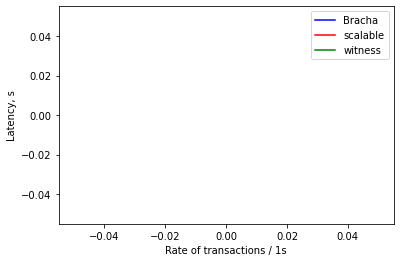

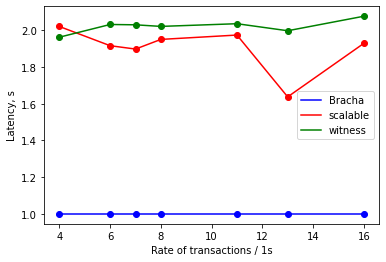

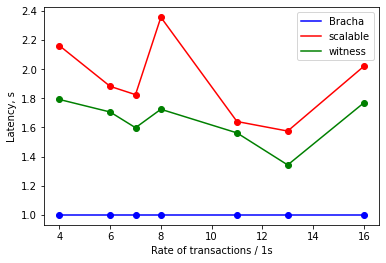

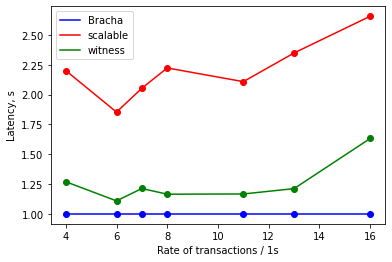

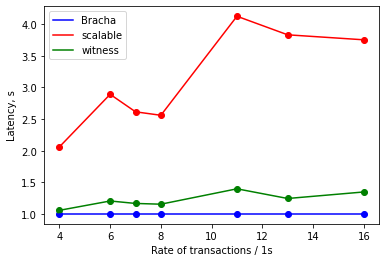

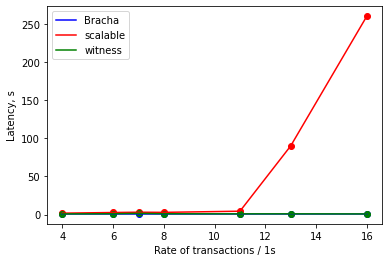

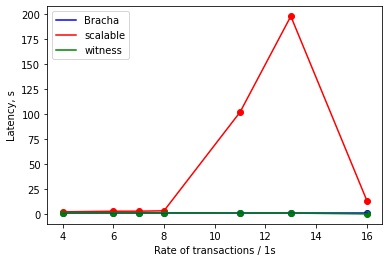

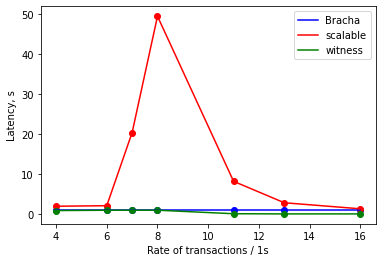

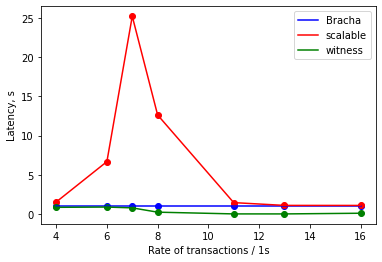

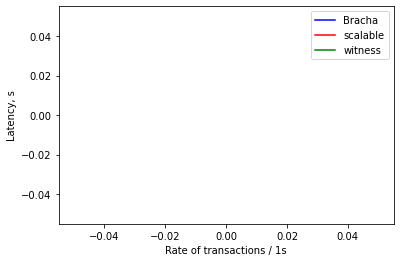

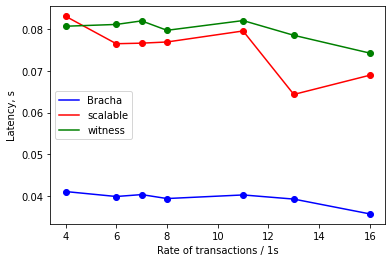

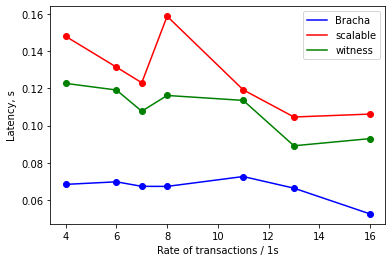

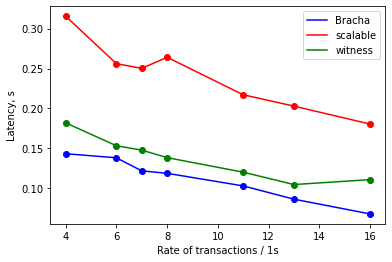

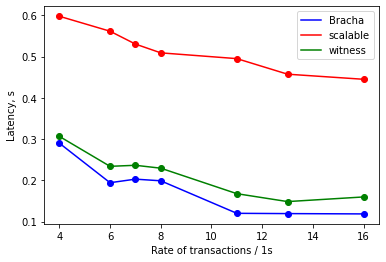

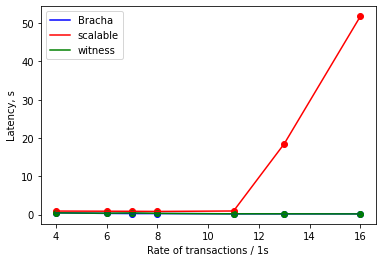

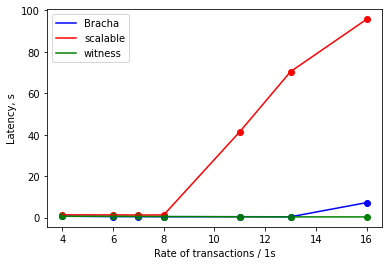

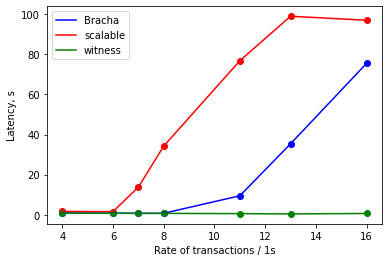

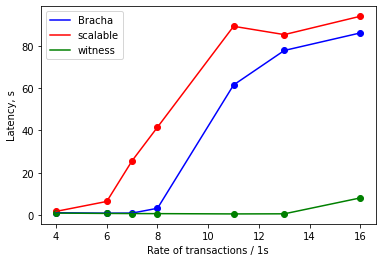

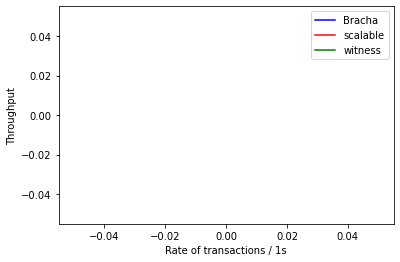

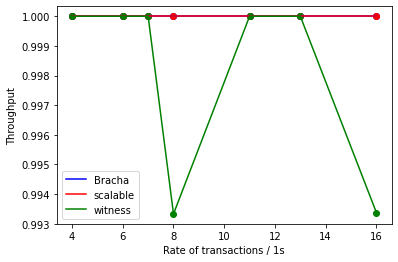

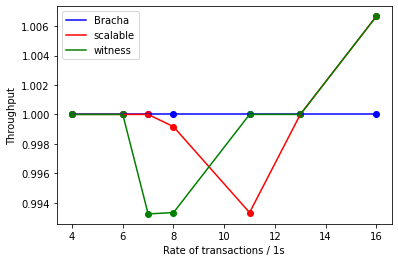

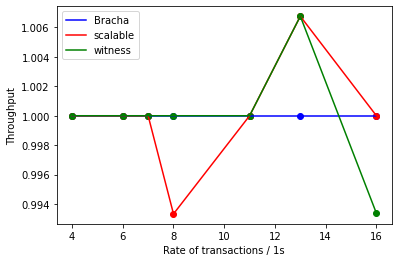

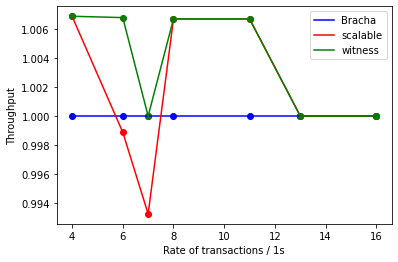

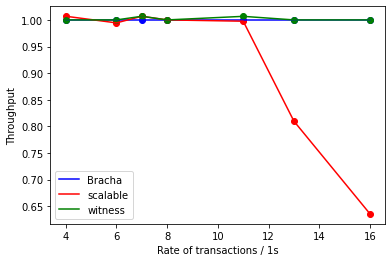

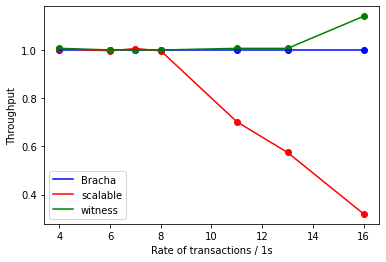

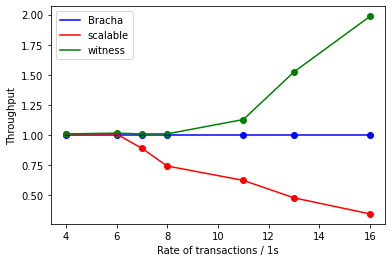

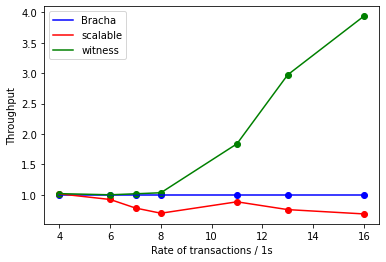

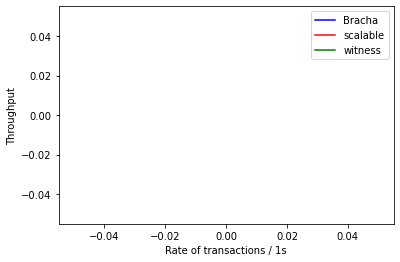

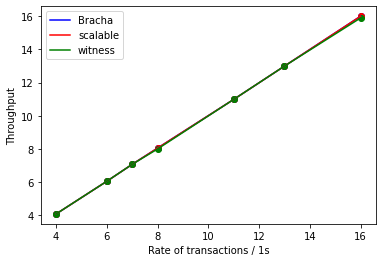

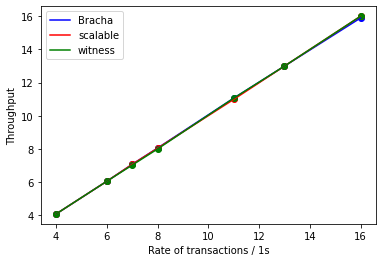

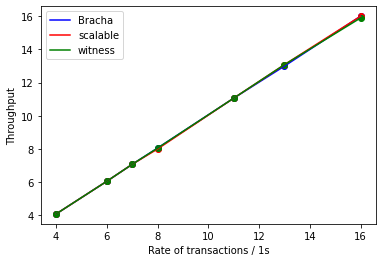

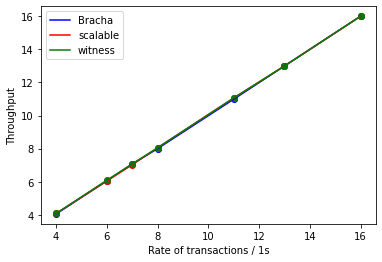

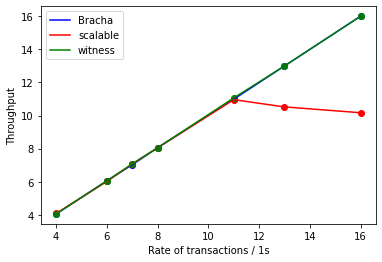

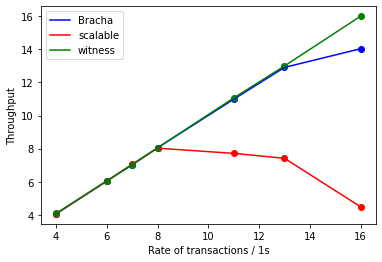

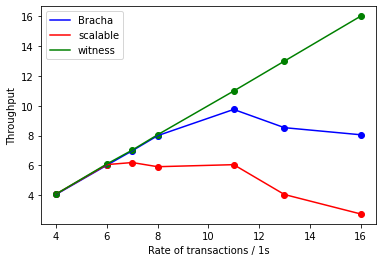

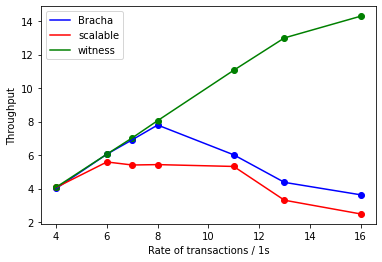

In [28]:
for metrics in "avg_transaction_latency", "avg_throughput":
    for is_normalized in True, False:
        for n in ns:
            build_rate_to_metrics(
                n=n,
                metrics=metrics,
                is_normalized=is_normalized
            )

In [22]:
def build_n_metrics(
        rate,
        metrics="avg_transaction_latency",
        is_normalized=False
):
    protocol_to_stat = {}
    for protocol in PROTOCOLS:
        protocol_to_stat[protocol] = {}

    for n, n_stat in config_statistics.items():
        for protocol, protocol_stat in n_stat.items():
            protocol_to_stat[protocol][n] = float(protocol_stat[rate][metrics])

    if is_normalized:
        for n in ns:
            for protocol in PROTOCOLS:
                if protocol == "bracha":
                    continue
                protocol_to_stat[protocol][n] /= protocol_to_stat["bracha"][n]

            protocol_to_stat["bracha"][n] = 1.0

    for protocol in PROTOCOLS:
        plot(protocol, protocol_to_stat[protocol])

    plt.xlabel(xlabel="Number of processes")
    plt.ylabel(ylabel=metrics_to_label[metrics])
    plt.legend()

    parameter = metrics.split("_")[-1]
    output_dir = "normalized" if is_normalized else "absolute"
    output_path = f"graphs/n_{parameter}/{output_dir}"
    Path(output_path).mkdir(parents=True, exist_ok=True)

    plt.savefig(f"{output_path}/{rate}.png")
    plt.show()

{'bracha': {160: 1.0, 128: 1.0, 256: 1.0, 32: 1.0, 64: 1.0, 224: 1.0, 96: 1.0, 192: 1.0}, 'scalable': {160: 260.0918107546405, 128: 3.753674293182542, 256: 1.0914561868369832, 32: 1.9283277126664973, 64: 2.0190053992323342, 224: 1.284471636296718, 96: 2.655708990914629, 192: 13.292697170555975}, 'witness': {160: 0.9404921856995743, 128: 1.3471941774061382, 256: 0.09517344347908599, 32: 2.076114740229788, 64: 1.7684133304347787, 224: 0.007916342077634232, 96: 1.6317370137096332, 192: 0.04088564110563366}}


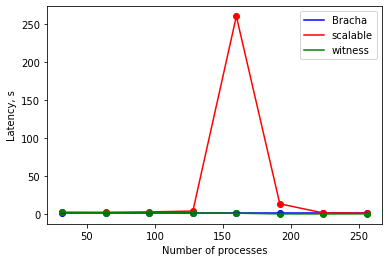

In [25]:
build_n_metrics(
    rate=16,
    metrics="avg_transaction_latency",
    is_normalized=True
)

{'bracha': {160: 1.0, 128: 1.0, 256: 1.0, 32: 1.0, 64: 1.0, 224: 1.0, 96: 1.0, 192: 1.0}, 'scalable': {160: 260.0918107546405, 128: 3.753674293182542, 256: 1.0914561868369832, 32: 1.9283277126664973, 64: 2.0190053992323342, 224: 1.284471636296718, 96: 2.655708990914629, 192: 13.292697170555975}, 'witness': {160: 0.9404921856995743, 128: 1.3471941774061382, 256: 0.09517344347908599, 32: 2.076114740229788, 64: 1.7684133304347787, 224: 0.007916342077634232, 96: 1.6317370137096332, 192: 0.04088564110563366}}


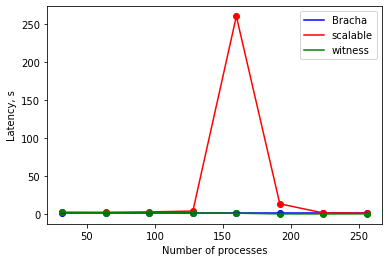

{'bracha': {160: 0.19905868728625, 128: 0.11852413816125, 256: 86.01353199038803, 32: 0.03575319385291666, 64: 0.052594566366666665, 224: 75.53053447470792, 96: 0.06796898262291667, 192: 7.1999164965975}, 'scalable': {160: 51.773534422722506, 128: 0.44490101053750003, 256: 93.88000164260978, 32: 0.06894387452291666, 64: 0.10618871346458333, 224: 97.01682920709375, 96: 0.180505838255, 192: 95.70630964256088}, 'witness': {160: 0.18721313988833332, 128: 0.15967502881291668, 256: 8.18620402532375, 32: 0.07422773276833333, 64: 0.09300893227125, 224: 0.5979255482083333, 96: 0.11090750473000001, 192: 0.29437320187041666}}


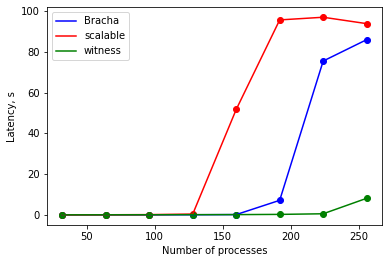

{'bracha': {160: 1.0, 128: 1.0, 256: 1.0, 32: 1.0, 64: 1.0, 224: 1.0, 96: 1.0, 192: 1.0}, 'scalable': {160: 0.635593220338983, 128: 1.0, 256: 0.6854034451495921, 32: 1.0, 64: 1.0066666666666666, 224: 0.3409460946094609, 96: 1.0, 192: 0.31968129139072854}, 'witness': {160: 1.0, 128: 1.0, 256: 3.937313819453439, 32: 0.9933774834437086, 64: 1.0066666666666666, 224: 1.9866666666666664, 96: 0.9933774834437086, 192: 1.1400000000000001}}


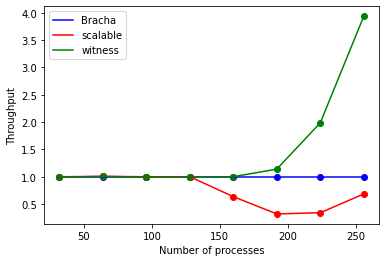

{'bracha': {160: 16.0, 128: 16.0, 256: 3.6282894736842106, 32: 16.0, 64: 15.894039735099337, 224: 8.053691275167786, 96: 16.0, 192: 14.035087719298245}, 'scalable': {160: 10.169491525423728, 128: 16.0, 256: 2.486842105263158, 32: 16.0, 64: 16.0, 224: 2.745874587458746, 96: 16.0, 192: 4.486754966887418}, 'witness': {160: 16.0, 128: 16.0, 256: 14.285714285714286, 32: 15.894039735099337, 64: 16.0, 224: 16.0, 96: 15.894039735099337, 192: 16.0}}


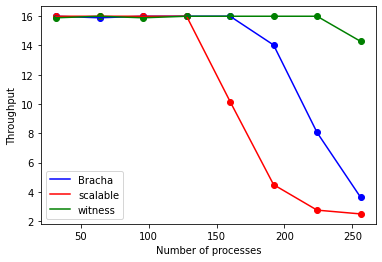

In [26]:
for metrics in "avg_transaction_latency", "avg_throughput":
    for is_normalized in True, False:
        build_n_metrics(
            rate=16,
            metrics=metrics,
            is_normalized=is_normalized
        )